In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from abnumber import Chain
from bin.evaluation import plot_roc_curve, plot_oasis_curves, adjust_box_widths, plot_precision_recall_curve
from scipy import stats
from matplotlib import ticker, lines
from sklearn import metrics
from bin.utils import iterate_fasta

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [3]:
SPECIES = ['Human', 'Humanized', 'Chimeric', 'Mouse']
SPECIES_COLORS = ['tab:blue', 'tab:green', 'tab:orange', '#dd0033']
COLORS = dict(zip(SPECIES, SPECIES_COLORS))
TASK_DIR = '../../data/tasks/humanness'
PREFIX = os.path.join(TASK_DIR, 'imgt_mab_db')

In [4]:
mabs_full = pd.read_csv(PREFIX+'.tsv', sep='\t', index_col=0)
mabs_full.head()

,Antibody,Species
INN_Number,,
8659,abagovomab,Mouse
10881,abelacimab,Human
9509,abituzumab,Humanized
10745,abrezekimab,Humanized
9921,abrilumab,Human


In [5]:
mabs_full['Species'].value_counts()

Humanized             229
Human                 198
Chimeric               63
Humanized/Chimeric     41
Mouse                  13
Human/Humanized         7
Caninized               6
Human/Chimeric          4
Felinized               3
Name: Species, dtype: int64

In [6]:
mabs = mabs_full[mabs_full['Species'].isin([
    'Humanized',
    'Human',
    'Humanized/Chimeric',
    'Chimeric',
    'Mouse',
    'Caninized',
    'Felinized'
])]
print('Selected mabs:', len(mabs))
mabs['Species'].value_counts()

Selected mabs: 553


Humanized             229
Human                 198
Chimeric               63
Humanized/Chimeric     41
Mouse                  13
Caninized               6
Felinized               3
Name: Species, dtype: int64

In [7]:
def seq_id_to_inn(seq_id):
    return int(seq_id.split('_')[0])

# Humanness scores

## OASis

In [8]:
oasis_curves = pd.read_excel(PREFIX+'_oasis.xlsx', sheet_name='OASis Curves', index_col=0)
# NOTE: we are calculating mean of all chains at each threshold - this will cause equal weighing to chains of different length
oasis_curves = oasis_curves.groupby(oasis_curves.index.map(seq_id_to_inn)).mean().loc[mabs.index]
oasis_curves.head()

,0%,1%,2%,3%,4%,5%,6%,7%,8%,9%,...,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%
INN_Number,,,,,,,,,,,,,,,,,,,,,
8659,1.0,0.636773,0.550778,0.541223,0.526072,0.503549,0.483893,0.470379,0.455774,0.446765,...,0.191646,0.191646,0.191646,0.182091,0.182091,0.182091,0.182091,0.182091,0.182091,0.182091
10881,1.0,0.915893,0.906089,0.901187,0.881579,0.881579,0.881579,0.877193,0.877193,0.877193,...,0.776058,0.776058,0.776058,0.776058,0.776058,0.776058,0.776058,0.776058,0.776058,0.776058
9509,1.0,0.814141,0.805051,0.780303,0.780303,0.766162,0.766162,0.761616,0.761616,0.757071,...,0.625253,0.625253,0.625253,0.625253,0.625253,0.620707,0.620707,0.620707,0.620707,0.616162
10745,1.0,0.846456,0.811688,0.787608,0.787608,0.773043,0.763528,0.759064,0.754013,0.754013,...,0.603535,0.603535,0.603535,0.603535,0.603535,0.589556,0.589556,0.589556,0.584506,0.584506
9921,1.0,0.990909,0.986364,0.986364,0.986364,0.986364,0.986364,0.986364,0.986364,0.986364,...,0.862121,0.857576,0.857576,0.857576,0.857576,0.857576,0.857576,0.852525,0.842424,0.842424


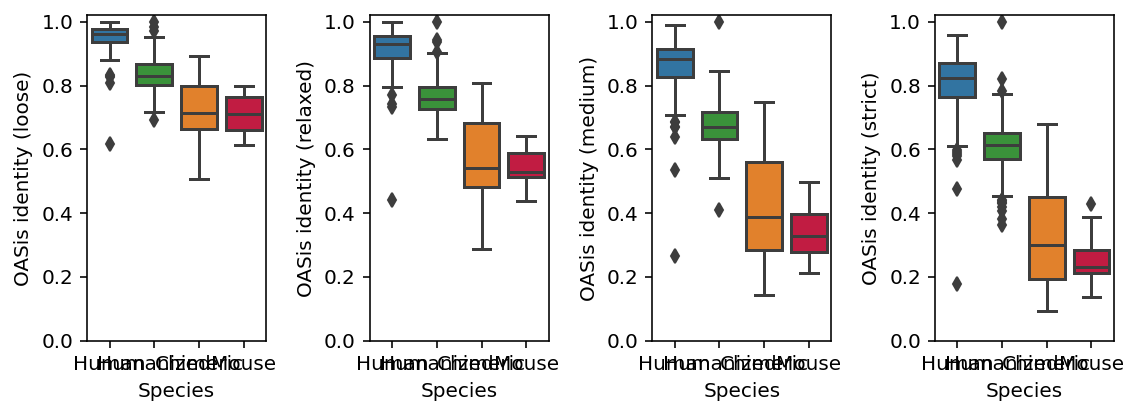

In [9]:
oasis_loose = oasis_curves['1%'].rename('OASis identity (loose)')
oasis_relaxed = oasis_curves['10%'].rename('OASis identity (relaxed)')
oasis_medium = oasis_curves['50%'].rename('OASis identity (medium)')
oasis_strict = oasis_curves['90%'].rename('OASis identity (strict)')

fig, axes = plt.subplots(1, 4, figsize=(8, 3))
sns.boxplot(y=oasis_loose, x=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[0])
sns.boxplot(y=oasis_relaxed, x=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[1])
sns.boxplot(y=oasis_medium, x=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[2])
sns.boxplot(y=oasis_strict, x=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[3])
for ax in axes:
    ax.set_ylim(0, 1.02);
fig.tight_layout();

In [10]:
mabs.join(oasis_relaxed[mabs['Species'] == 'Human'], how='inner').sort_values(oasis_relaxed.name)

,Antibody,Species,OASis identity (relaxed)
INN_Number,,,
10988,elipovimab,Human,0.441844
9431,sirukumab,Human,0.733729
9976,navivumab,Human,0.742797
11133,manelimab,Human,0.771672
9779,vantictumab,Human,0.793939
...,...,...,...
9921,abrilumab,Human,0.986364
9123,rilotumumab,Human,0.990000
10903,ontamalimab,Human,0.991379


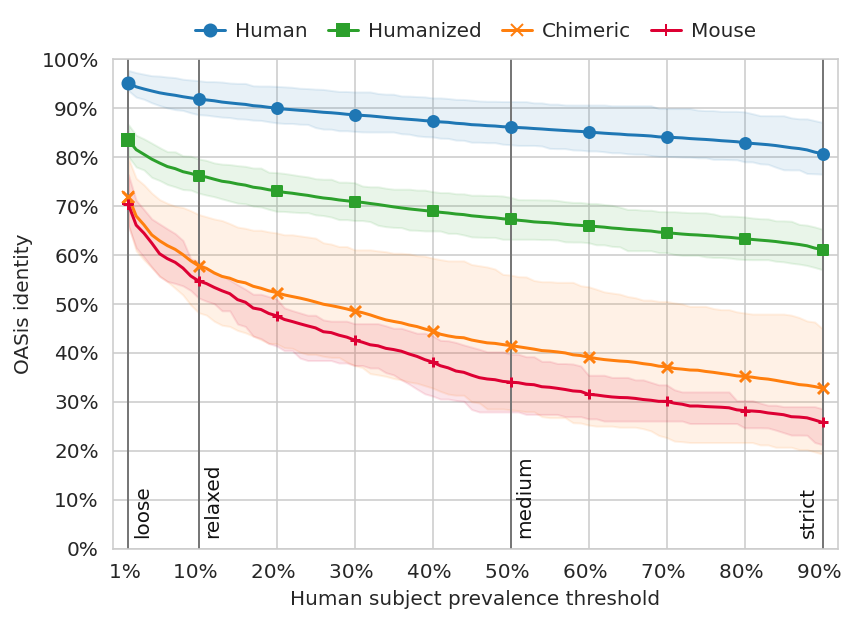

In [11]:
plot_oasis_curves(oasis_curves, groupby=mabs['Species'], errorbars=False, colors=dict(zip(SPECIES, SPECIES_COLORS)))

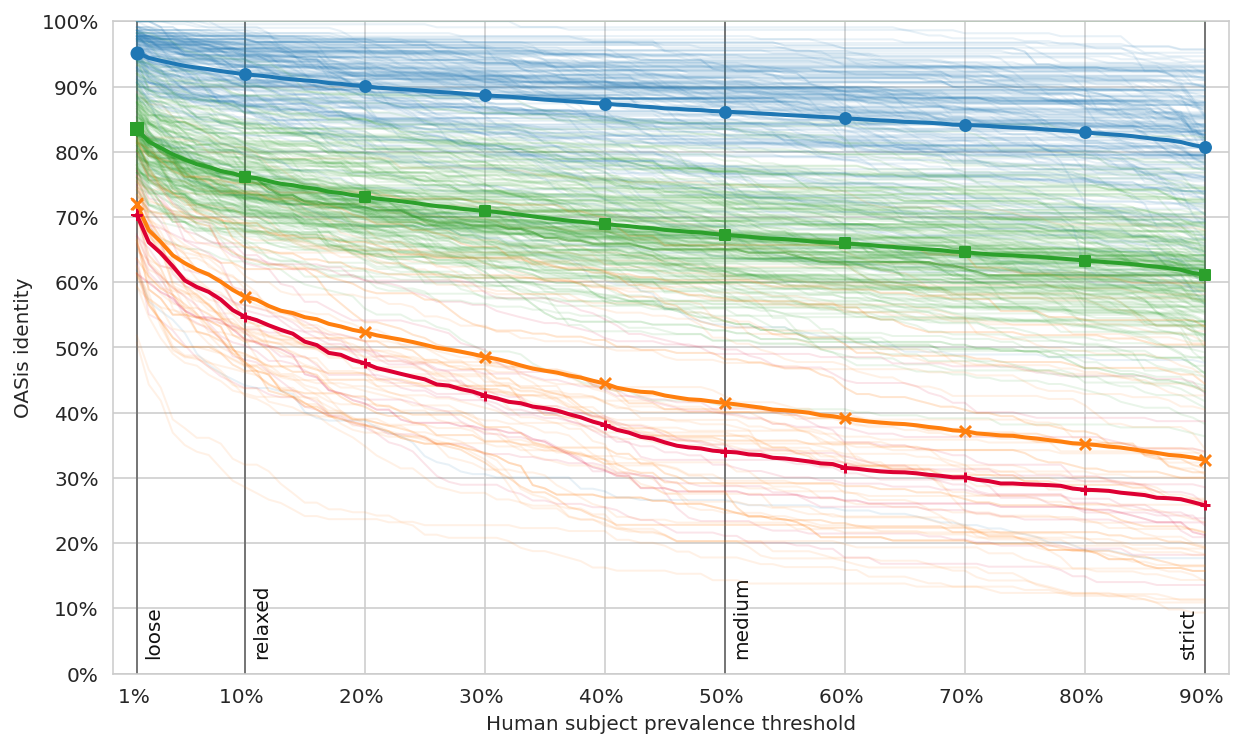

In [12]:
seq_colors = {row.name: COLORS[row['Species']] for i, row in mabs.iterrows() if row['Species'] in COLORS}
plot_oasis_curves(oasis_curves, colors=seq_colors, lw=1, figsize=(10, 6), mark=False, 
                  alpha=0.1, legend=False, thresholds=False)
plt.gca().legend().remove()
plot_oasis_curves(oasis_curves.groupby(mabs['Species']).mean(), ax=plt.gca(), alpha=1, 
                  lw=2, colors=dict(zip(SPECIES, SPECIES_COLORS)))
plt.gca().legend().remove()

## Hu-mAb

In [13]:
humab = pd.read_csv(PREFIX+'_humab.tsv', sep='\t', index_col=0)['Hu-mAb']
humab = humab.groupby(humab.index.map(seq_id_to_inn)).mean()
humab = humab.loc[mabs.index]
humab.head()

INN_Number
8659     0.0250
10881    1.0000
9509     0.5245
10745    0.7660
9921     0.9980
Name: Hu-mAb, dtype: float64

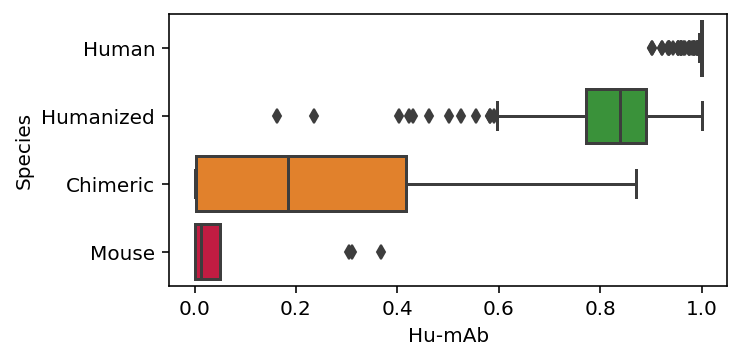

In [14]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=humab, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

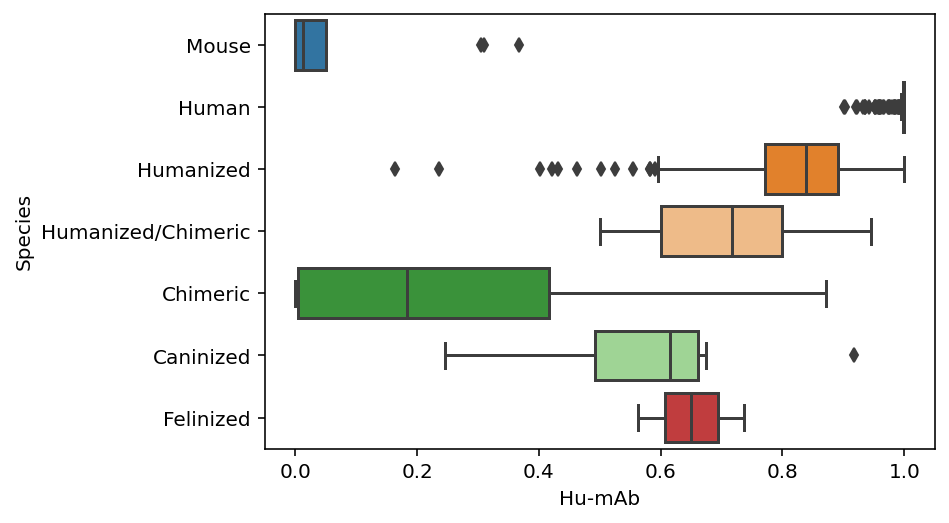

In [15]:
sns.boxplot(x=humab, y=mabs['Species'], palette='tab20');

## MG Score

In [16]:
mg = pd.read_csv(PREFIX+'_MG.tsv', sep='\t').set_index('Long name', verify_integrity=True)['Score']
mg = mg.groupby(mg.index.map(lambda n: n.replace('_1','').replace('_2',''))).mean()
mg = mg.reindex(mabs['Antibody'])
mg.index = mabs.index
mg.name = 'MG Score'
mg.head()

INN_Number
8659     5303.898980
10881    8798.541684
9509     7027.174840
10745    7188.634019
9921     9019.816661
Name: MG Score, dtype: float64

In [17]:
len(mg[mg.isna()])

7

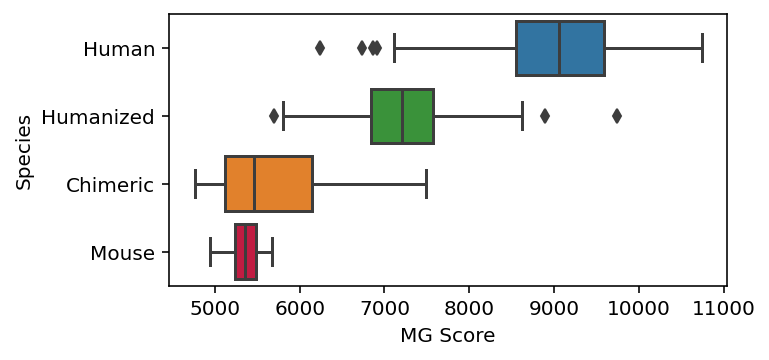

In [18]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=mg, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

## T20 Score

In [17]:
t20 = pd.read_csv(PREFIX+'_T20.tsv', sep='\t', index_col=0)['t20'].rename('T20')
t20 = t20.groupby(t20.index.map(seq_id_to_inn)).mean()
t20 = t20.loc[mabs.index]
t20.head()

INN_Number
8659     67.553070
10881    87.562970
9509     80.234320
10745    82.162620
9921     90.070785
Name: T20, dtype: float64

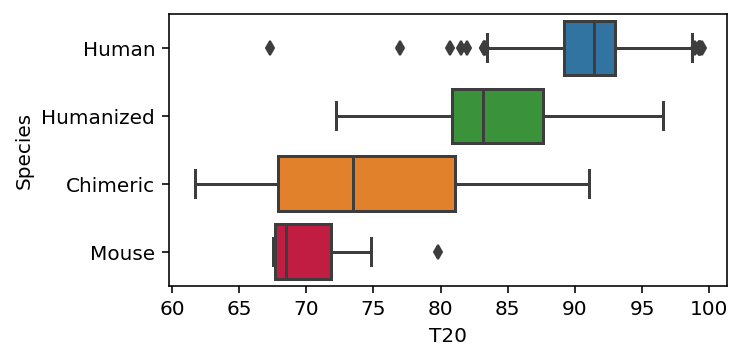

In [18]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=t20, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

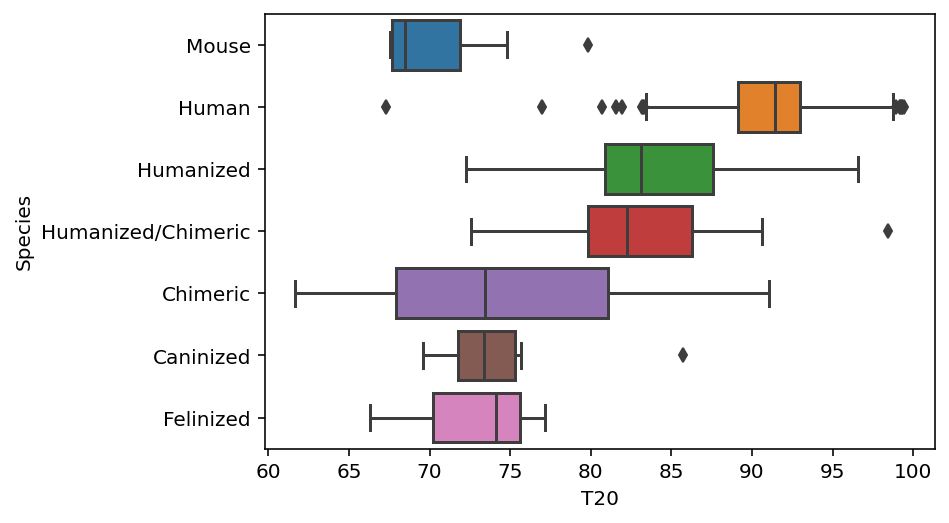

In [19]:
sns.boxplot(x=t20, y=mabs['Species'], palette='tab10');

## Z-Score

In [20]:
zscore = pd.read_csv(PREFIX+'_Zscore.tsv', sep='\t', index_col=0)['zscore'].rename('Z-score')
zscore = zscore.groupby(zscore.index.map(seq_id_to_inn)).mean()
zscore = zscore.loc[mabs.index]
zscore.head()

INN_Number
8659    -1.6235
10881    1.3010
9509    -0.1645
10745   -0.6055
9921     0.1330
Name: Z-score, dtype: float64

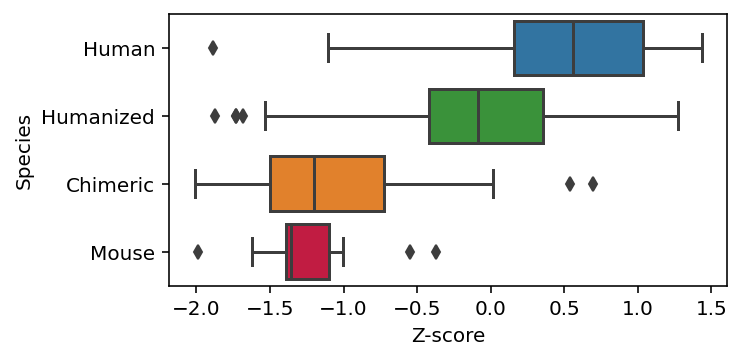

In [21]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=zscore, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

## AbLSTM Score

In [22]:
ablstm = pd.read_csv(PREFIX+'_AbLSTM.tsv', sep='\t', index_col=0)['AbLSTM_score'].rename('AbLSTM')
ablstm = ablstm.groupby(ablstm.index.map(seq_id_to_inn)).mean()
ablstm = ablstm.reindex(mabs.index)
ablstm.head()

INN_Number
8659     1.304958
10881    0.405249
9509     1.007186
10745    0.866728
9921     0.272131
Name: AbLSTM, dtype: float64

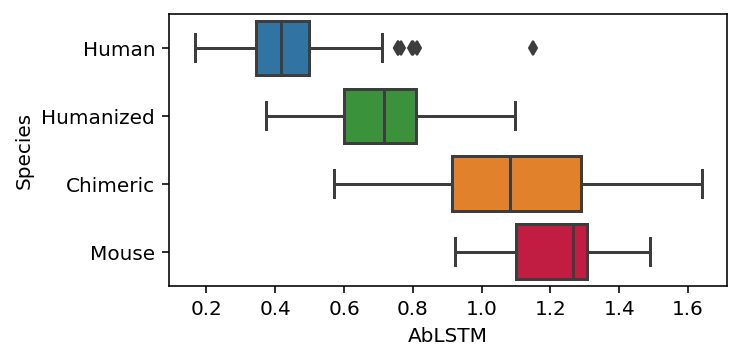

In [23]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=ablstm, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

## IgReconstruct Score

In [24]:
igreconstruct = pd.read_csv(PREFIX+'_IgReconstruct.tsv', sep='\t', index_col=0)['Human-Likeness (GenBank)']
igreconstruct = igreconstruct.groupby(igreconstruct.index.map(seq_id_to_inn)).mean().rename('IgReconstruct')
igreconstruct = igreconstruct.loc[mabs.index]
igreconstruct.head()

INN_Number
8659    -2.992780
10881   -0.145395
9509    -1.206491
10745   -0.798039
9921     0.830371
Name: IgReconstruct, dtype: float64

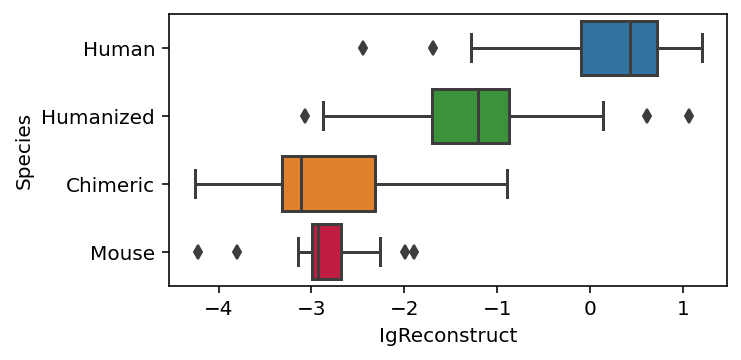

In [25]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=igreconstruct, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

## Germline content

In [26]:
germline_content = pd.read_csv(PREFIX+'_GC.tsv', sep='\t', index_col=0)['germline_content']
germline_content = germline_content.groupby(germline_content.index.map(seq_id_to_inn)).mean().rename('Germline content')
germline_content = germline_content.reindex(mabs.index)
germline_content.head()

INN_Number
8659     0.669324
10881    0.888525
9509     0.798551
10745    0.830919
9921     0.929590
Name: Germline content, dtype: float64

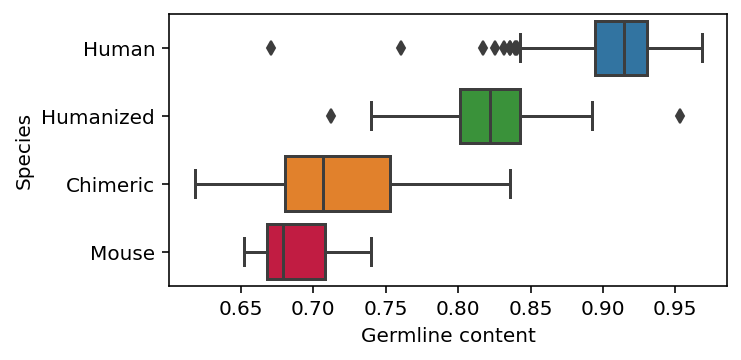

In [27]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.boxplot(x=germline_content, y=mabs['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=ax);

# Human mAbs scores

In [28]:
human_mabs = mabs[mabs['Species'] == 'Human']
len(human_mabs)

198

In [29]:
human_mabs.join(oasis_medium).sort_values(oasis_medium.name).head(10)

,Antibody,Species,OASis identity (medium)
INN_Number,,,
10988,elipovimab,Human,0.266171
9976,navivumab,Human,0.535339
9431,sirukumab,Human,0.640053
9975,firivumab,Human,0.669521
11133,manelimab,Human,0.670279
10691,cemiplimab,Human,0.686081
9779,vantictumab,Human,0.686364
10783,otilimab,Human,0.707617
9757,tosatoxumab,Human,0.708953


In [30]:
human_mabs.join(humab).sort_values(humab.name).head(10)

,Antibody,Species,Hu-mAb
INN_Number,,,
10638,atidortoxumab,Human,0.9010
10988,elipovimab,Human,0.9025
10639,berlimatoxumab,Human,0.9215
9431,sirukumab,Human,0.9225
11174,narsoplimab,Human,0.9325
9643,evolocumab,Human,0.9350
10257,lupartumab amadotin,Human,0.9350
10258,lupartumab,Human,0.9350
10041,elgemtumab,Human,0.9425


# Evaluation

In [31]:
SCORES = [
    (zscore, '-', 'tab:brown', 1.5),
    (t20, '-', '#eecc00', 1.5),
    (-ablstm, '-', 'tab:red', 1.5),
    (mg, '-', 'black', 1.5),
    (igreconstruct, '-', 'tab:cyan', 1.5),
    (germline_content, '-', 'tab:green', 1.5),
    (humab, '-', '#ff9698', 1.5),
    (oasis_loose, ':', '#a020c0', 1.5),
    (oasis_relaxed, '-.', '#a020c0', 1.5),
    (oasis_medium, '--', '#a020c0', 1.5),
    (oasis_strict, '-', '#a020c0', 1.5)
]
SELECTED_SCORES = [
    (zscore, '-', 'tab:brown', 1.0),
    (t20, '-', '#eecc00', 1.0),
    (-ablstm, '-', 'tab:red', 1.0),
    (mg, '-', 'black', 1.0),
    (igreconstruct, '-', 'tab:cyan', 1.0),
    (germline_content, '-', 'tab:green', 1.0),
    (humab, '-', '#ff9698', 1.0),
    (oasis_medium.rename('OASis identity'), '-', '#a020c0', 1.5),
]

In [32]:
def plot_rocs(y, scores, figsize=(8, 8), ax=None, lw_scale=1, baseline=True):
    print('Classes:', y.value_counts().to_dict())
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    for i, (score, ls, color, lw) in enumerate(scores):
        shared_index = y.index[~score.loc[y.index].isna()]
        if len(shared_index) != len(y.index):
            print()
            print(f'Note! Evaluating only {len(shared_index)}/{len(y.index)} samples for {score.name}')
            print()
        plot_roc_curve(
            y.loc[shared_index], 
            score.loc[shared_index], 
            baseline=baseline and (i == len(scores)-1), 
            label=score.name, 
            lw=lw*lw_scale, 
            color=color, 
            ls=ls, 
            ax=ax
        );

In [33]:
def get_performance(y, scores):
    performance = []
    for score, ls, color, lw in scores:
        shared_index = y.index[~score.loc[y.index].isna()]
        if len(shared_index) != len(y.index):
            print()
            print(f'Note! Evaluating only {len(shared_index)}/{len(y.index)} samples for {score.name}')
            print()
        score = score.loc[shared_index]

        performance.append({
            'Method': score.name,
            'Accuracy': max(metrics.accuracy_score(y.loc[shared_index], score >= threshold) for threshold in score),
            'ROC AUC': metrics.roc_auc_score(y.loc[shared_index], score)
        })
    return pd.DataFrame(performance).set_index('Method')

# Therapeutic classification

## Human VS non-human

Classes: {False: 355, True: 198}
Z-score: 0.837 AUC
T20: 0.896 AUC

Note! Evaluating only 549/553 samples for AbLSTM

AbLSTM: 0.937 AUC

Note! Evaluating only 546/553 samples for MG Score

MG Score: 0.959 AUC
IgReconstruct: 0.967 AUC
Germline content: 0.968 AUC
Hu-mAb: 0.977 AUC
OASis identity (loose): 0.964 AUC
OASis identity (relaxed): 0.972 AUC
OASis identity (medium): 0.966 AUC
OASis identity (strict): 0.956 AUC


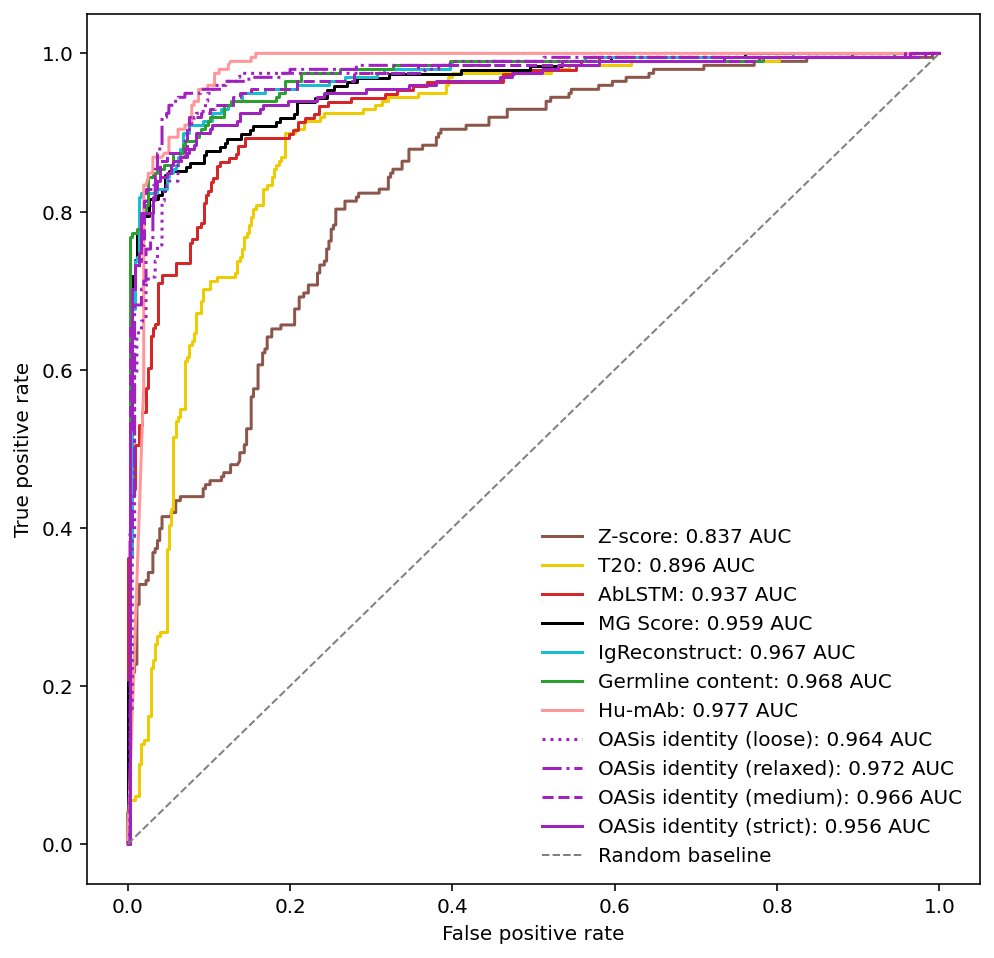

In [34]:
plot_rocs(mabs['Species'] == 'Human', SCORES)

Classes: {False: 355, True: 198}
Z-score: 0.837 AUC
T20: 0.896 AUC

Note! Evaluating only 549/553 samples for AbLSTM

AbLSTM: 0.937 AUC

Note! Evaluating only 546/553 samples for MG Score

MG Score: 0.959 AUC
IgReconstruct: 0.967 AUC
Germline content: 0.968 AUC
Hu-mAb: 0.977 AUC
OASis identity: 0.966 AUC


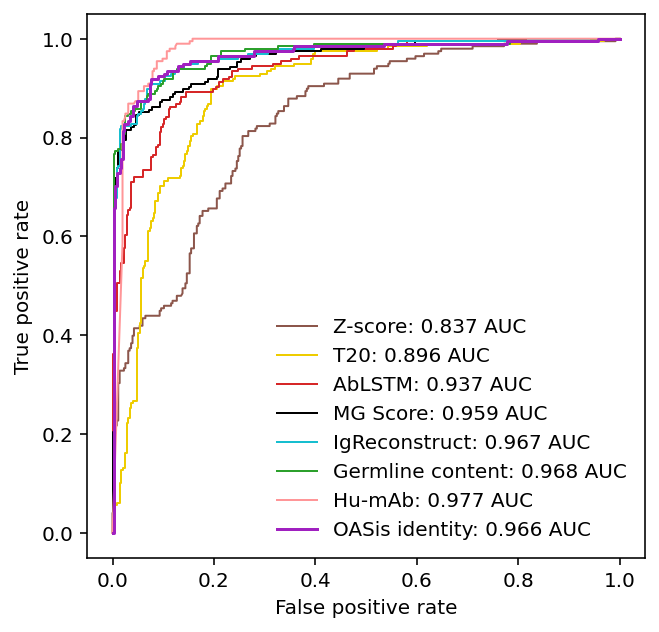

In [35]:
plot_rocs(mabs['Species'] == 'Human', SELECTED_SCORES, figsize=(5, 5), baseline=False)
plt.gca().legend(loc='lower right', frameon=False);

In [36]:
human_classification = get_performance(mabs['Species'] == 'Human', SCORES)
human_classification.apply(lambda col: col.apply('{:.1%}'.format))


Note! Evaluating only 549/553 samples for AbLSTM


Note! Evaluating only 546/553 samples for MG Score



,Accuracy,ROC AUC
Method,,
Z-score,76.5%,83.7%
T20,83.9%,89.6%
AbLSTM,87.8%,93.7%
MG Score,91.8%,95.9%
IgReconstruct,92.6%,96.7%
Germline content,92.8%,96.8%
Hu-mAb,93.3%,97.7%
OASis identity (loose),91.9%,96.4%
OASis identity (relaxed),94.4%,97.2%


## Human & Humanized VS Chimeric or Murine

Classes: {True: 427, False: 126}
Z-score: 0.864 AUC
T20: 0.855 AUC

Note! Evaluating only 549/553 samples for AbLSTM

AbLSTM: 0.872 AUC

Note! Evaluating only 546/553 samples for MG Score

MG Score: 0.918 AUC
IgReconstruct: 0.911 AUC
Germline content: 0.914 AUC
Hu-mAb: 0.944 AUC
OASis identity (loose): 0.876 AUC
OASis identity (relaxed): 0.895 AUC
OASis identity (medium): 0.910 AUC
OASis identity (strict): 0.917 AUC


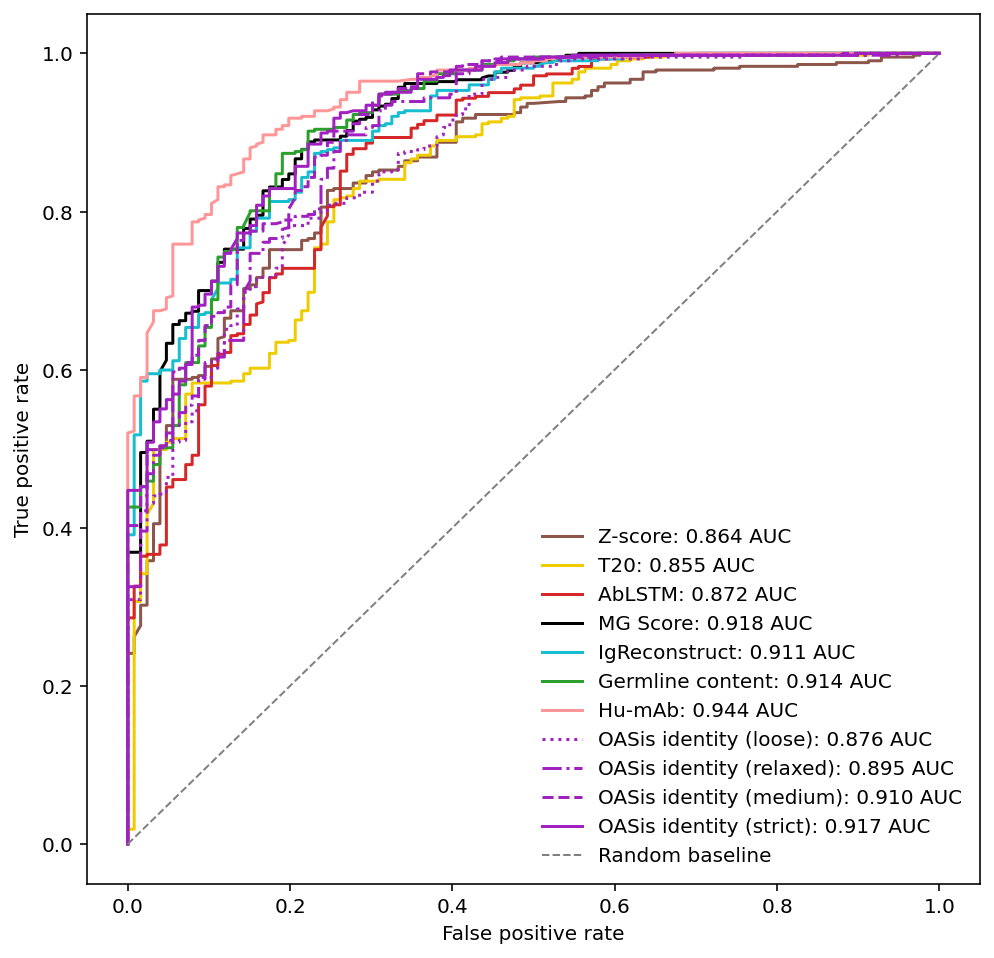

In [37]:
plot_rocs((mabs['Species'] == 'Human') | (mabs['Species'] == 'Humanized'), SCORES)

## Humanized VS Chimeric or murine

In [38]:
mabs_humanized_chimeric_murine = mabs[mabs['Species'].isin(['Humanized','Chimeric','Mouse','Caninized','Felinized'])]
assert mabs_humanized_chimeric_murine['Species'].nunique() == 5
mabs_humanized_chimeric_murine['Species'].value_counts()

Humanized    229
Chimeric      63
Mouse         13
Caninized      6
Felinized      3
Name: Species, dtype: int64

Classes: {True: 229, False: 85}
Z-score: 0.870 AUC
T20: 0.859 AUC

Note! Evaluating only 312/314 samples for AbLSTM

AbLSTM: 0.910 AUC

Note! Evaluating only 310/314 samples for MG Score

MG Score: 0.944 AUC
IgReconstruct: 0.930 AUC
Germline content: 0.958 AUC
Hu-mAb: 0.958 AUC
OASis identity (loose): 0.885 AUC
OASis identity (relaxed): 0.921 AUC
OASis identity (medium): 0.944 AUC
OASis identity (strict): 0.949 AUC


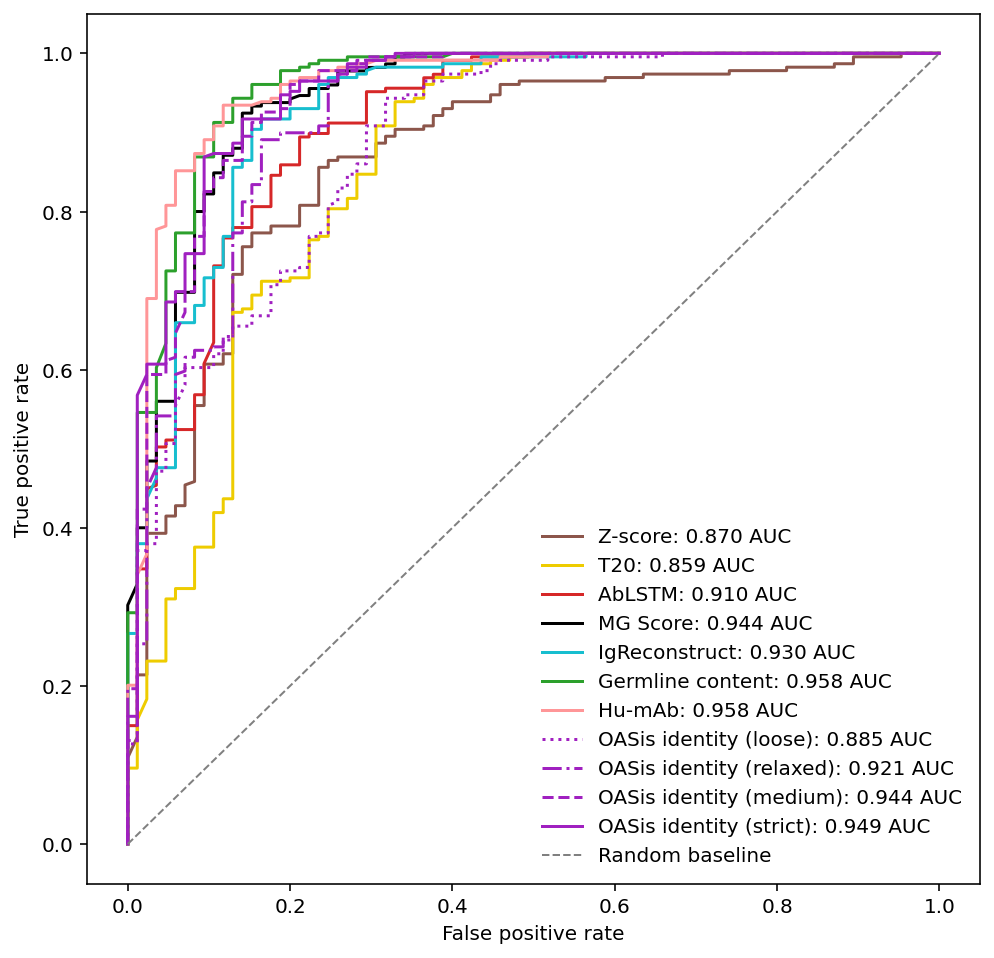

In [39]:
plot_rocs(mabs_humanized_chimeric_murine['Species'] == 'Humanized', SCORES)

Classes: {True: 229, False: 85}
Z-score: 0.870 AUC
T20: 0.859 AUC

Note! Evaluating only 312/314 samples for AbLSTM

AbLSTM: 0.910 AUC

Note! Evaluating only 310/314 samples for MG Score

MG Score: 0.944 AUC
IgReconstruct: 0.930 AUC
Germline content: 0.958 AUC
Hu-mAb: 0.958 AUC
OASis identity: 0.944 AUC


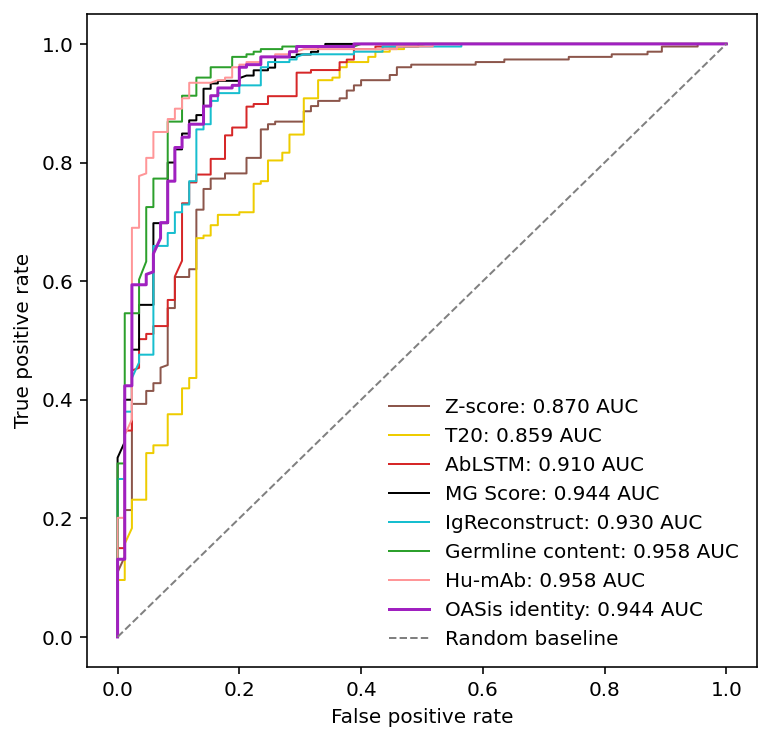

In [40]:
plot_rocs(mabs_humanized_chimeric_murine['Species'] == 'Humanized', SELECTED_SCORES, figsize=(6, 6))

In [41]:
humanized_classification = get_performance(mabs_humanized_chimeric_murine['Species'] == 'Humanized', SCORES)
humanized_classification.apply(lambda col: col.apply('{:.1%}'.format))


Note! Evaluating only 312/314 samples for AbLSTM


Note! Evaluating only 310/314 samples for MG Score



,Accuracy,ROC AUC
Method,,
Z-score,84.7%,87.0%
T20,87.6%,85.9%
AbLSTM,88.8%,91.0%
MG Score,91.3%,94.4%
IgReconstruct,91.1%,93.0%
Germline content,93.3%,95.8%
Hu-mAb,92.0%,95.8%
OASis identity (loose),87.6%,88.5%
OASis identity (relaxed),91.7%,92.1%


# Score correlation

In [42]:
full_score_table = pd.DataFrame([s[0] for s in SCORES]).T
full_score_table.head()

,Z-score,T20,AbLSTM,MG Score,IgReconstruct,Germline content,Hu-mAb,OASis identity (loose),OASis identity (relaxed),OASis identity (medium),OASis identity (strict)
INN_Number,,,,,,,,,,,
8659,-1.6235,67.553070,-1.304958,5303.898980,-2.992780,0.669324,0.0250,0.636773,0.437756,0.233825,0.182091
10881,1.3010,87.562970,-0.405249,8798.541684,-0.145395,0.888525,1.0000,0.915893,0.877193,0.812693,0.776058
9509,-0.1645,80.234320,-1.007186,7027.174840,-1.206491,0.798551,0.5245,0.814141,0.757071,0.671212,0.616162
10745,-0.6055,82.162620,-0.866728,7188.634019,-0.798039,0.830919,0.7660,0.846456,0.754013,0.677309,0.584506
9921,0.1330,90.070785,-0.272131,9019.816661,0.830371,0.929590,0.9980,0.990909,0.986364,0.880303,0.842424


In [43]:
selected_score_table = pd.DataFrame([s[0] for s in SELECTED_SCORES]).T
selected_score_table.head()

,Z-score,T20,AbLSTM,MG Score,IgReconstruct,Germline content,Hu-mAb,OASis identity
INN_Number,,,,,,,,
8659,-1.6235,67.553070,-1.304958,5303.898980,-2.992780,0.669324,0.0250,0.233825
10881,1.3010,87.562970,-0.405249,8798.541684,-0.145395,0.888525,1.0000,0.812693
9509,-0.1645,80.234320,-1.007186,7027.174840,-1.206491,0.798551,0.5245,0.671212
10745,-0.6055,82.162620,-0.866728,7188.634019,-0.798039,0.830919,0.7660,0.677309
9921,0.1330,90.070785,-0.272131,9019.816661,0.830371,0.929590,0.9980,0.880303


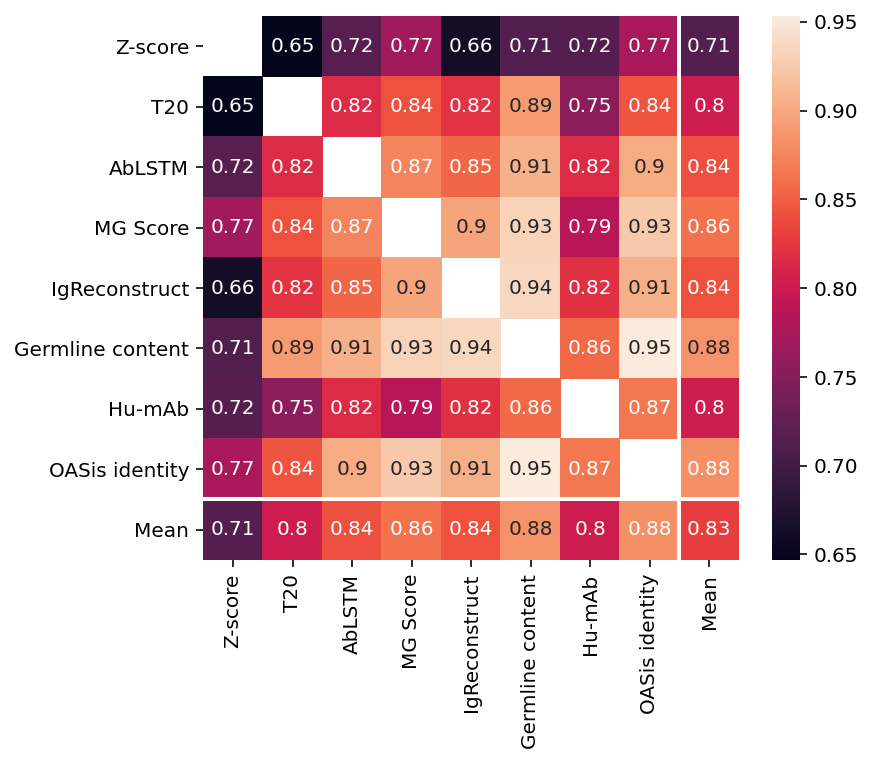

In [44]:
score_corr = selected_score_table.corr()
score_corr[np.eye(*score_corr.shape).astype(bool)] = np.nan
score_corr = pd.concat([score_corr, pd.DataFrame([score_corr.mean().rename('Mean')])])
score_corr = pd.concat([score_corr, pd.DataFrame(score_corr.mean(axis=1).rename('Mean'))], axis=1)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(score_corr, annot=True, ax=ax);
ax.axhline(len(score_corr)-1, lw=2, color='white');
ax.axvline(len(score_corr)-1, lw=2, color='white');

## Main figure

In [45]:
oasis_percentiles = pd.read_csv(PREFIX+'_percentile.tsv', sep='\t', index_col=0)
oasis_percentiles.head()

,1%,2%,3%,4%,5%,6%,7%,8%,9%,10%,...,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%
humanness,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


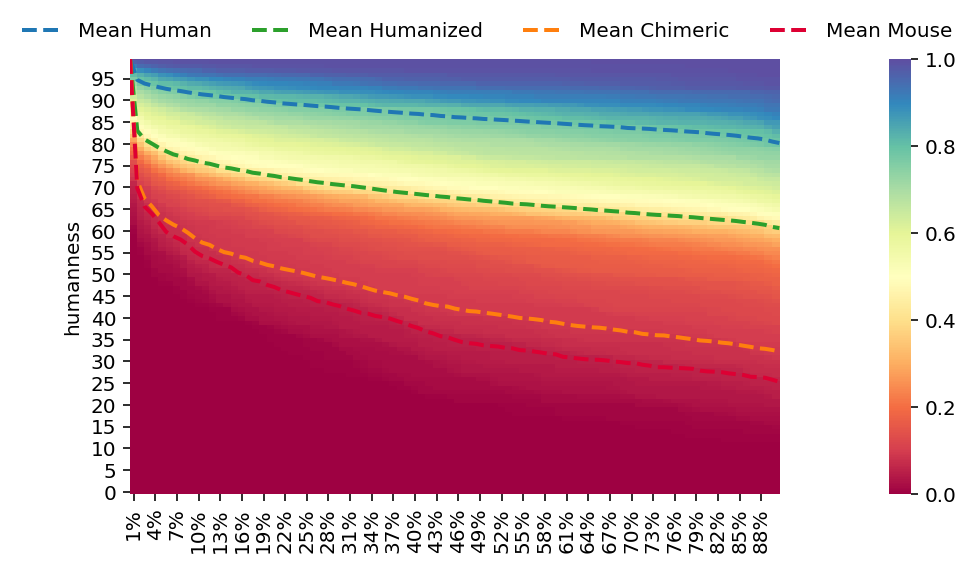

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
(oasis_curves.groupby(mabs['Species']).mean() * 100).T[SPECIES].add_prefix('Mean ').plot(ax=ax, lw=2, ls='--', color=SPECIES_COLORS);
sns.heatmap(oasis_percentiles, cmap='Spectral', ax=ax)
ax.set_ylim(0, 100);
ax.set_xlim(0, 99);
ax.legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.5, 1));

In [47]:

OASIS_THRESHOLDS = {
    'loose': '1%',
    'relaxed': '10%',
    'medium': '50%',
    'strict': '90%'
}
    

In [48]:
print("Mean")
oasis_curves.groupby(mabs['Species']).mean()[OASIS_THRESHOLDS.values()]

Mean


,1%,10%,50%,90%
Species,,,,
Caninized,0.770447,0.644206,0.482556,0.402862
Chimeric,0.719515,0.578005,0.414983,0.327658
Felinized,0.788322,0.680781,0.455396,0.361483
Human,0.952138,0.918809,0.861660,0.807028
Humanized,0.835265,0.761884,0.672750,0.611313
Humanized/Chimeric,0.813255,0.737932,0.620451,0.548294
Mouse,0.703385,0.547166,0.340237,0.257894


In [49]:
print("Median")
oasis_curves.groupby(mabs['Species']).median()[OASIS_THRESHOLDS.values()]

Median


,1%,10%,50%,90%
Species,,,,
Caninized,0.784557,0.659566,0.493547,0.414909
Chimeric,0.714286,0.542857,0.388934,0.300837
Felinized,0.800505,0.708081,0.454545,0.361510
Human,0.961207,0.930401,0.882095,0.824454
Humanized,0.830696,0.756620,0.668421,0.613929
Humanized/Chimeric,0.814773,0.727893,0.644363,0.561598
Mouse,0.710499,0.527778,0.327610,0.231742


In [50]:
print('Median Percentile:')
oasis_curves.groupby(mabs['Species']).median()[OASIS_THRESHOLDS.values()].apply(lambda col: oasis_percentiles[col.name].loc[(col*100).astype(int)].values)

Median Percentile:


,1%,10%,50%,90%
Species,,,,
Caninized,0.191489,0.122340,0.118794,0.125887
Chimeric,0.065603,0.069149,0.076241,0.079787
Felinized,0.242908,0.193262,0.099291,0.101064
Human,0.806738,0.812057,0.810284,0.808511
Humanized,0.388298,0.372340,0.374113,0.398936
Humanized/Chimeric,0.287234,0.258865,0.296099,0.257092
Mouse,0.065603,0.051418,0.046099,0.049645


In [51]:
def plot_signif(ax, a, b, level, offset=0.04, top=1.08):
    y = top+level*offset
    line = lines.Line2D([a, b], [y, y], lw=1, color='black')
    line.set_clip_on(False)
    ax.add_line(line)
    line = lines.Line2D([a, a], [y, y - offset*0.33], lw=1, color='black')
    line.set_clip_on(False)
    ax.add_line(line)
    line = lines.Line2D([b, b], [y, y - offset*0.33], lw=1, color='black')
    line.set_clip_on(False)
    ax.add_line(line)
    

In [52]:
for series in [oasis_loose, oasis_relaxed, oasis_medium, oasis_strict]:
    print('')
    print(series.name)
    for species1 in SPECIES:
        for species2 in SPECIES:
            if species2 >= species1:
                continue
            _, pval = stats.mannwhitneyu(
                x=series[mabs['Species'] == species1],
                y=series[mabs['Species'] == species2],
                alternative='two-sided'
            )
            if pval <= 0.05:
                if pval <= 0.00001:
                    stars = '*****'
                elif pval <= 0.0001:
                    stars = '****'
                elif pval <= 0.001:
                    stars = '***'
                elif pval <= 0.01:
                    stars = '**'
                else:
                    stars = '*'
                print(f' {species1} x {species2}: {stars} (p = {pval:e})')


OASis identity (loose)
 Human x Chimeric: ***** (p = 4.528009e-32)
 Humanized x Human: ***** (p = 3.133295e-59)
 Humanized x Chimeric: ***** (p = 2.333178e-20)
 Mouse x Human: ***** (p = 2.212164e-09)
 Mouse x Humanized: ***** (p = 2.243591e-08)

OASis identity (relaxed)
 Human x Chimeric: ***** (p = 3.950905e-32)
 Humanized x Human: ***** (p = 9.990052e-62)
 Humanized x Chimeric: ***** (p = 4.781193e-23)
 Mouse x Human: ***** (p = 2.277004e-09)
 Mouse x Humanized: ***** (p = 1.464296e-09)

OASis identity (medium)
 Human x Chimeric: ***** (p = 4.849550e-32)
 Humanized x Human: ***** (p = 2.425397e-59)
 Humanized x Chimeric: ***** (p = 1.176463e-25)
 Mouse x Human: ***** (p = 2.212579e-09)
 Mouse x Humanized: ***** (p = 1.427727e-09)

OASis identity (strict)
 Human x Chimeric: ***** (p = 6.817219e-32)
 Humanized x Human: ***** (p = 1.457045e-55)
 Humanized x Chimeric: ***** (p = 1.754944e-26)
 Mouse x Human: ***** (p = 2.277111e-09)
 Mouse x Humanized: ***** (p = 1.579502e-09)


Classes: {False: 355, True: 198}
Z-score: 0.837 AUC
T20: 0.896 AUC

Note! Evaluating only 549/553 samples for AbLSTM

AbLSTM: 0.937 AUC

Note! Evaluating only 546/553 samples for MG Score

MG Score: 0.959 AUC
IgReconstruct: 0.967 AUC
Germline content: 0.968 AUC
Hu-mAb: 0.977 AUC
OASis identity: 0.966 AUC


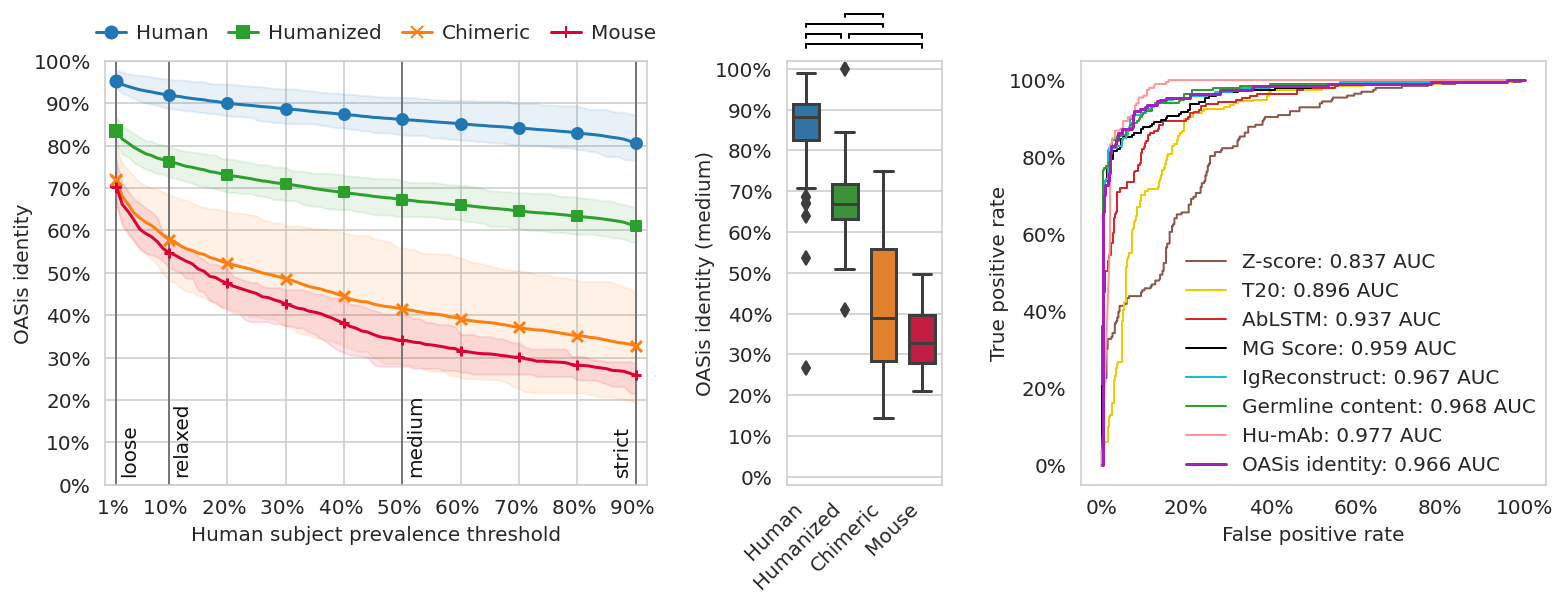

In [53]:
with sns.axes_style('whitegrid', rc={'font.family': 'DejaVu Sans'}):
    fig, axes = plt.subplots(1, 3, figsize=(11, 4.3), gridspec_kw=dict(width_ratios=[3.5, 1, 3]))

    ax = axes[0]
    plot_oasis_curves(
        oasis_curves, 
        groupby=mabs['Species'], 
        errorbars=False,
        ax=ax, 
        fill_alpha=0.1,
        colors=dict(zip(SPECIES, SPECIES_COLORS))
    )
    ax.yaxis.labelpad = 0

    ax = axes[1]
    sns.boxplot(
        x=mabs['Species'], 
        y=oasis_medium, 
        order=SPECIES, palette=SPECIES_COLORS, 
        ax=ax, 
        width=0.95, 
        linewidth=1.5
    );
    adjust_box_widths(ax, 0.70)
    ax.set_ylim(-0.02, 1.02)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.set_ylabel('OASis identity (medium)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.yaxis.labelpad = 0
    ax.margins()

    plot_signif(ax, 0, 3, level=0, offset=0.025, top=1.06)
    plot_signif(ax, 0, 0.9, level=1, offset=0.025, top=1.06)
    plot_signif(ax, 1.1, 3, level=1, offset=0.025, top=1.06)
    plot_signif(ax, 0, 2, level=2, offset=0.025, top=1.06)
    plot_signif(ax, 1, 2, level=3, offset=0.025, top=1.06)

    ax = axes[2]
    plot_rocs(mabs['Species'] == 'Human', SELECTED_SCORES, ax=ax, baseline=False)
    ax.legend(loc='lower right', frameon=False, borderpad=0);
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: '{:.0%}'.format(v))) 
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: '{:.0%}'.format(v))) 
    ax.yaxis.labelpad = 0
    ax.grid(False)

    plt.tight_layout(h_pad=2.5, w_pad=1.5);  
    fig.savefig('../../data/figures/main/fig3a.png', bbox_inches='tight', backend='agg', dpi=300)


Classes: {False: 355, True: 198}
Z-score: 0.837 AUC
T20: 0.896 AUC

Note! Evaluating only 549/553 samples for AbLSTM

AbLSTM: 0.937 AUC

Note! Evaluating only 546/553 samples for MG Score

MG Score: 0.959 AUC
IgReconstruct: 0.967 AUC
Germline content: 0.968 AUC
Hu-mAb: 0.977 AUC
OASis identity: 0.966 AUC


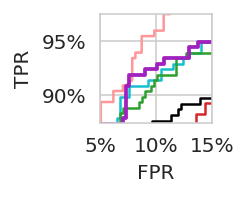

In [55]:
with sns.axes_style('whitegrid', rc={'font.family': 'DejaVu Sans'}):
    plot_rocs(mabs['Species'] == 'Human', SELECTED_SCORES, figsize=(1, 1), lw_scale=1.25, baseline=False)
    ax = plt.gca()
    ax.legend().remove()
    s = 0.10
    ax.set_xlim(0.1-s/2, 0.1+s/2)
    ax.set_ylim(0.925-s/2, 0.925+s/2)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    plt.gcf().patch.set_facecolor((0,0,0,0))

Classes: {False: 355, True: 198}
Z-score: 0.837 AUC
T20: 0.896 AUC

Note! Evaluating only 549/553 samples for AbLSTM

AbLSTM: 0.937 AUC

Note! Evaluating only 546/553 samples for MG Score

MG Score: 0.959 AUC
IgReconstruct: 0.967 AUC
Germline content: 0.968 AUC
Hu-mAb: 0.977 AUC
OASis identity: 0.966 AUC


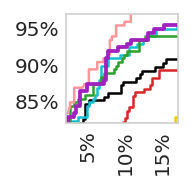

In [65]:
with sns.axes_style('whitegrid', rc={'font.family': 'DejaVu Sans'}):
    plot_rocs(mabs['Species'] == 'Human', SELECTED_SCORES, figsize=(1, 1), lw_scale=1.25, baseline=False)
    ax = plt.gca()
    ax.legend().remove()
    ax.grid(False)
    ax.set_xlim(0.02, 0.17)
    ax.set_xticks([0.05, 0.1, 0.15])
    ax.set_ylim(0.82, 0.97)
    ax.set_yticks([0.85, 0.9, 0.95])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(['{:.0%}'.format(v) for v in ax.get_xticks()], rotation=90)
    ax.set_yticklabels(['{:.0%}'.format(v) for v in ax.get_yticks()])
    ax.xaxis.set_tick_params(pad=0)
    ax.yaxis.set_tick_params(pad=0)
    plt.gcf().patch.set_facecolor((0,0,0,0))
    plt.gcf().savefig('../../data/figures/main/fig3c.png', bbox_inches='tight', backend='agg', dpi=300)


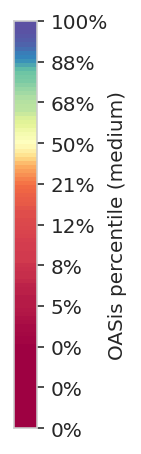

In [56]:
import matplotlib as mpl
import matplotlib.cm as cm

with sns.axes_style('whitegrid', rc={'font.family': 'DejaVu Sans'}):

    fig, ax = plt.subplots(figsize=(0.2, 3.745))

    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    threshold = '50%'
    ax.imshow(oasis_percentiles[[threshold]], cmap='Spectral', aspect='auto')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks(range(0, 101, 10))
    ax.set_yticklabels(['{:.0%}'.format(oasis_percentiles.loc[i, threshold]) for i in ax.get_yticks()])
    ax.set_ylabel('OASis percentile (medium)')

    ax.yaxis.labelpad = 0
    ax.grid(False)

    fig.patch.set_facecolor((0,0,0,0))
    fig.savefig('../../data/figures/main/fig3b.png', bbox_inches='tight', dpi=300);

# Table export

In [67]:
seqs = {}
for r in iterate_fasta(PREFIX+'.fa'):
    seq_id, seq_suffix = r.id.split('_')
    seq_id = int(seq_id)
    if seq_id not in seqs:
        seqs[seq_id] = []
    seqs[seq_id].append(str(r.seq))
len(seqs)

564

In [68]:
seqs[8659]

['QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS',
 'DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQLLVYNAKTLAGGVSSRFSGSGSGTHFSLKIKSLQPEDFGIYYCQHHYGILPTFGGGTKLEIK']

In [72]:
table = mabs
table['Seqs (comma-separated)'] = mabs.index.map(seqs.get).map(','.join)
for score, ls, color, lw in SCORES:
    table = table.join(score, how='outer')
table.index.name = 'INN Number'
table.head()

<ipython-input-72-030f0bdc8a5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['Seqs (comma-separated)'] = mabs.index.map(seqs.get).map(','.join)


,Antibody,Species,Seqs (comma-separated),Z-score,T20,AbLSTM,MG Score,IgReconstruct,Germline content,Hu-mAb,OASis identity (loose),OASis identity (relaxed),OASis identity (medium),OASis identity (strict)
INN Number,,,,,,,,,,,,,,
8659,abagovomab,Mouse,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLD...,-1.6235,67.553070,-1.304958,5303.898980,-2.992780,0.669324,0.0250,0.636773,0.437756,0.233825,0.182091
10881,abelacimab,Human,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNDVSWYQQLPGTAPK...,1.3010,87.562970,-0.405249,8798.541684,-0.145395,0.888525,1.0000,0.915893,0.877193,0.812693,0.776058
9509,abituzumab,Humanized,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,-0.1645,80.234320,-1.007186,7027.174840,-1.206491,0.798551,0.5245,0.814141,0.757071,0.671212,0.616162
10745,abrezekimab,Humanized,QVTLKESGPVLVKPTETLTLTCTVSGFSLTNYHVQWIRQPPGKALE...,-0.6055,82.162620,-0.866728,7188.634019,-0.798039,0.830919,0.7660,0.846456,0.754013,0.677309,0.584506
9921,abrilumab,Human,QVQLVQSGAEVKKPGASVKVSCKVSGYTLSDLSIHWVRQAPGKGLE...,0.1330,90.070785,-0.272131,9019.816661,0.830371,0.929590,0.9980,0.990909,0.986364,0.880303,0.842424


In [73]:
table.to_csv(PREFIX+'_all_scores.tsv', sep='\t')